# Algorithme de Grover
  
### Définition du problème

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

On veut rechercher dans une liste non ordonnée composée uniquement de 0 et d'un seul 1, l'indice de l'intrus : le 1  

Avec un algorithme classique cela prendait dans le pire des cas N itérations (Le 1 est à la fin de la liste), et en moyenne on met N/2 itérations pour trouver l'indice de l'intrus (le 1).

Grover a trouvé un algorithme quantique qui permet de résoudre ce problème beaucoup plus rapidement. On peut modéliser le problème à l'aide d'un Oracle : $f:{0,1}^n \rightarrow {0,1} $  
L'oracle (fonction boite noire) aura pour valeur 1, si l'index de l'élément est solution, 0 si il n'est recherché.

Cet oracle aura pour effet de marquer la bonne réponse parmit tout les états possibles de la superposition des qubits. Ainsi lors de la mesure nous aurons beaucoup plus de chances de mesurer la bonne réponse.  
  
On a le résultat de l'appel de l'oracle sur le premier registre ($\ket{x}^{\oplus n}$) pour :
$$\ket{x}^{\oplus n} \rightarrow (-1)^{f(x)} \ket{x}^{\oplus n}$$
  
On voit donc que seul les indices solutions seront marqués.  
  
Comme on a mis en superposition les qubits entrées on a :
![Oracle grover formule | 100](./images/oracle_grover.png)
  
Pour préciser et augmenter les probabilités de trouver la bonne réponse on doit répeter l'étape de l'oracle ainsi que l'étape de diffusion un certain nombre de fois en fonction du nombres de qubits.  
 

>On applique à chaque fois des Controlled Z gate, qui s'implémente à l'aide de portes H (Hadamard) sur le qubit target qui entoure un CNOT. 

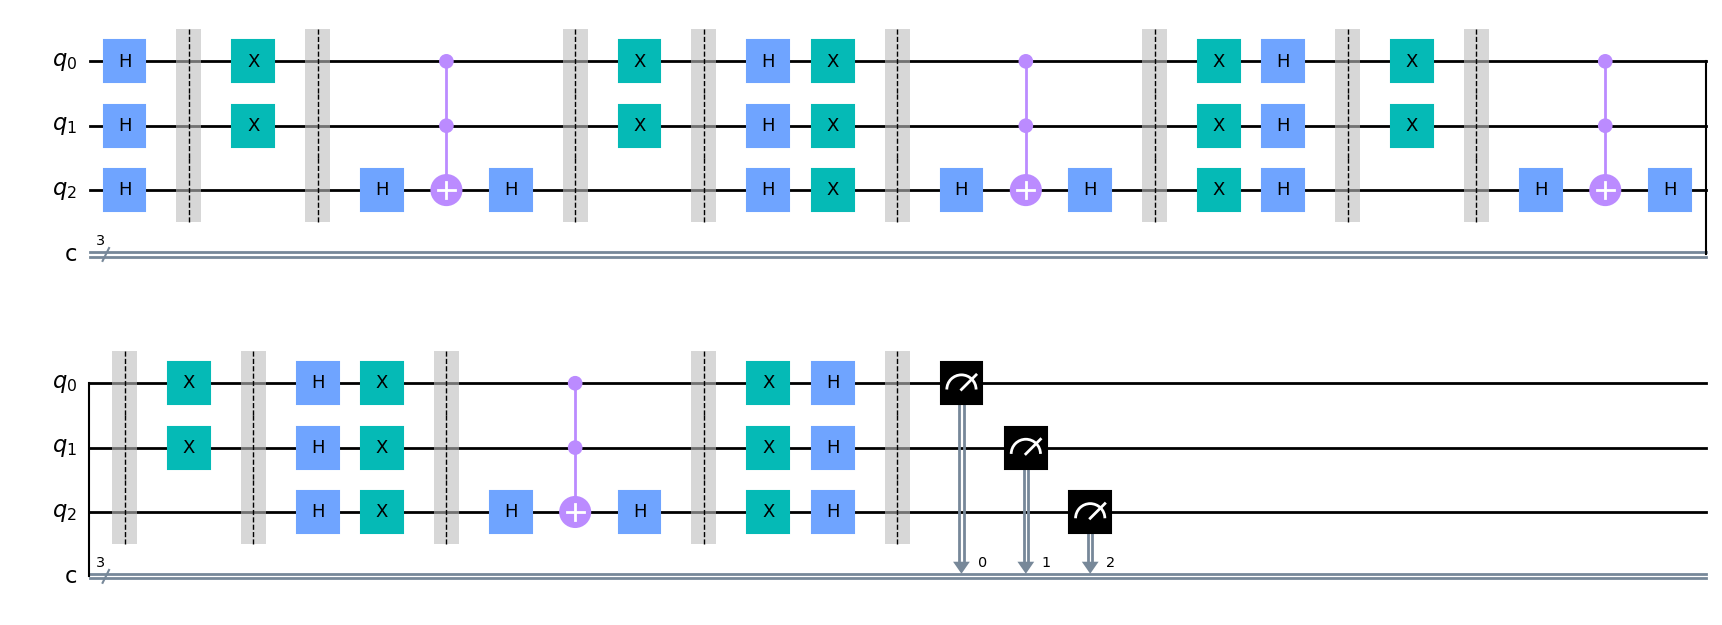

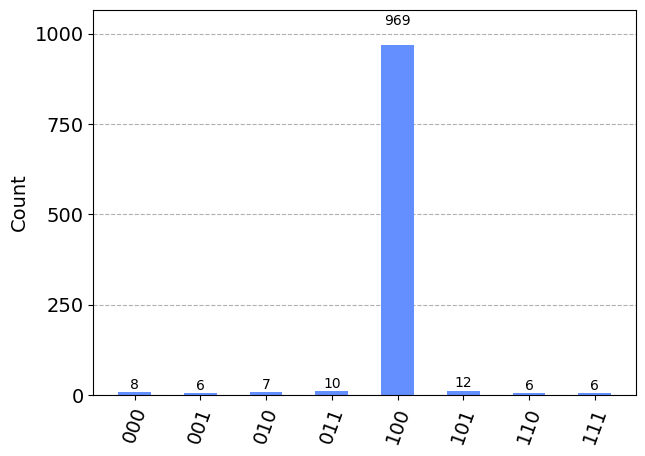

In [27]:
# initialization
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

def create_grover_circ( seeked_qubit, num_grover_iteration = 0): # seeked_qubit is a string that represent the qubit we're looking for
    seeked_qubit = seeked_qubit[::-1]
    n = len(seeked_qubit)
    qc = QuantumCircuit(n,n)
    for i in range(n):
        qc.h(i)
    qc.barrier()
    num_it= math.floor(math.sqrt(2**n)) # The number of diffuser depend of the number of qubit
    if num_grover_iteration:
        num_it =num_grover_iteration
    for i in range(num_it):
        create_oracle(qc, n, seeked_qubit)
        qc.barrier()
        create_diffuser(qc, n)
        qc.barrier()

    counts = measure_circ(qc, n)
    return qc, counts

def create_oracle(qc, n, seeked_qubit):

    for i in range(len(seeked_qubit)): # str to iterate through the qubit value
        if seeked_qubit[i] == '0':
            qc.x(i)
    qc.barrier()
    create_CCZgate(qc,n)
    qc.barrier()

    for i in range(len(seeked_qubit)): # str to iterate through the qubit value
        if seeked_qubit[i] == '0':      # We add a X gate when there is a zero (to mark the seeked value)
            qc.x(i)

def create_diffuser(qc, n):
    for i in range(n):
        qc.h(i)
    for i in range(n):
        qc.x(i)
    qc.barrier()
    create_CCZgate(qc,n)
    qc.barrier()
    for i in range(n):
        qc.x(i)
    for i in range(n):
        qc.h(i)

    return qc

def measure_circ(qc, n):
    for i in range(n):
        qc.measure(i,i)
    aer_sim = Aer.get_backend('aer_simulator')
    #transpiled_circuit = transpile(qc, aer_sim)
    qobj = assemble(qc,aer_sim)
    results = aer_sim.run(qobj).result()
    counts = results.get_counts()

    return counts


def create_CCZgate(qc, n): 
    qc.h(n-1)
    qc.mct(list(range(n-1)),n-1)
    qc.h(n-1)
    return qc




qc, counts = create_grover_circ('100') # we're looking for |100>
display(qc.draw('mpl'))
display(plot_histogram(counts))


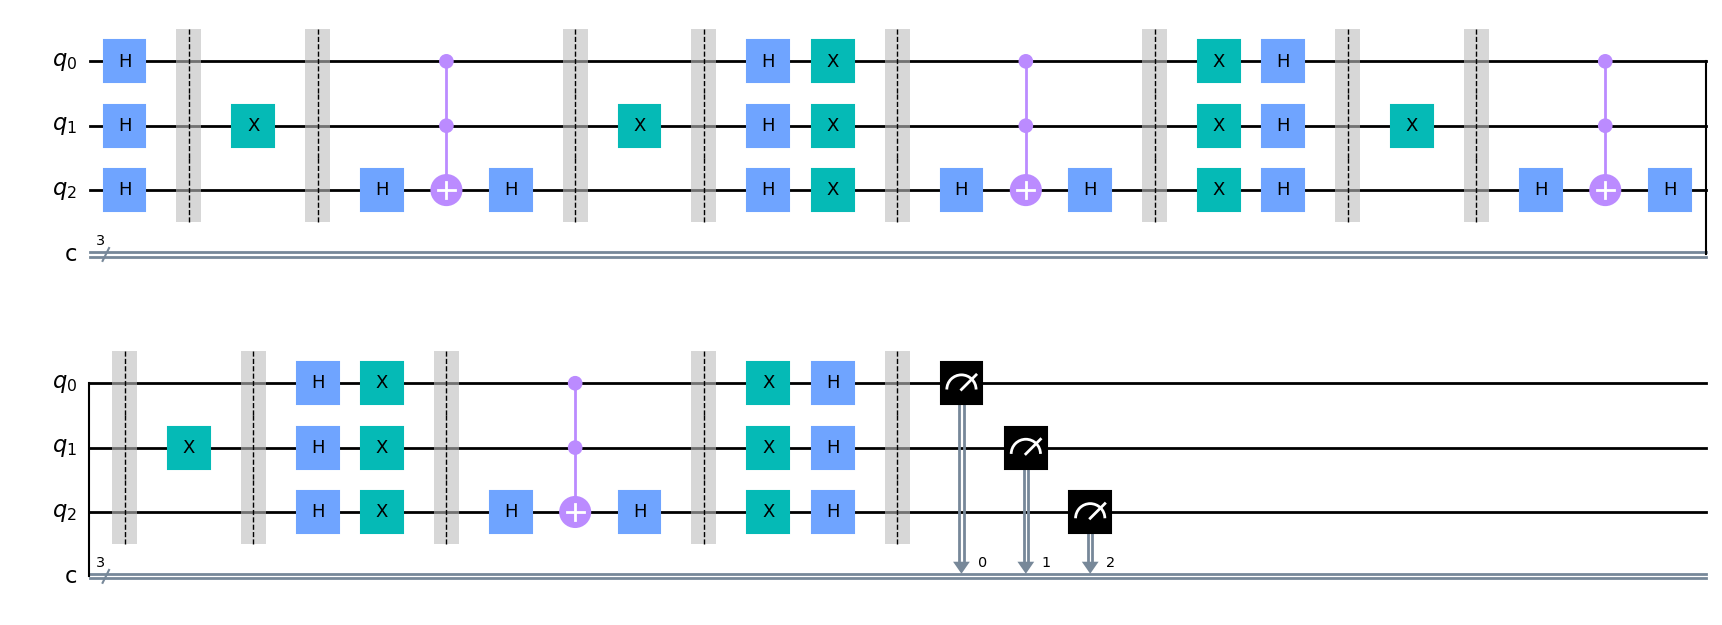

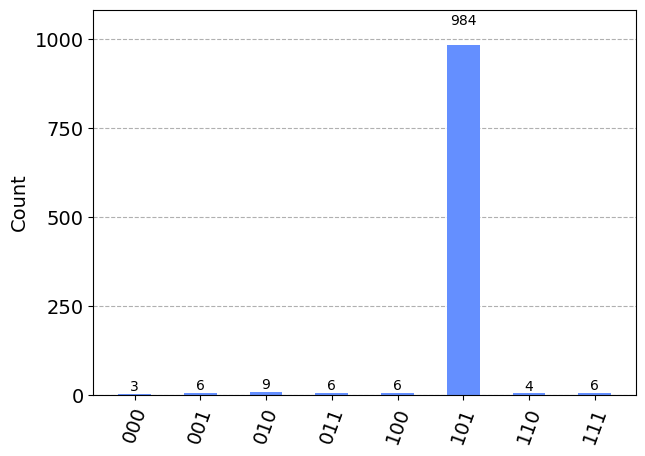

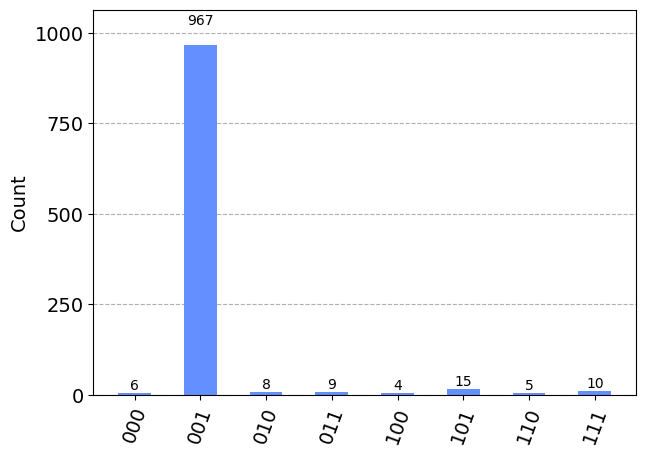

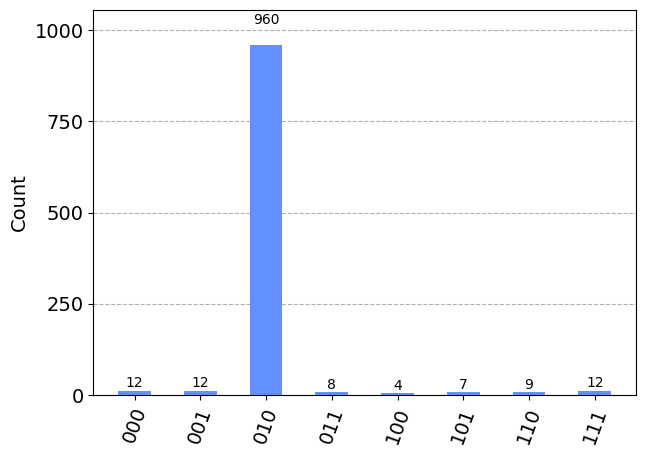

In [28]:
# trouver 101, 001 et 010 :
qc, counts1 = create_grover_circ('101')
display(qc.draw('mpl'))
display(plot_histogram(counts1))
qc, counts2 = create_grover_circ('001')
display(plot_histogram(counts2))
qc, counts3= create_grover_circ('010')
display(plot_histogram(counts3))

#### 3. Combien d'itérations de l'algorithme de Grover il faut exécuter pour trouver l'état |10101> ?

Pour touver avec précision un état de qubit, on a besoin de d'itérer plusieurs fois en fonction du nombre de qubits. Ici on a $n=5$, et on le nombre d'itération pour $\sqrt{2^n} $ .  D'où $\sqrt{2^5} \approx 5  $ on doit donc itérer 5 fois l'opérateur de Grover.

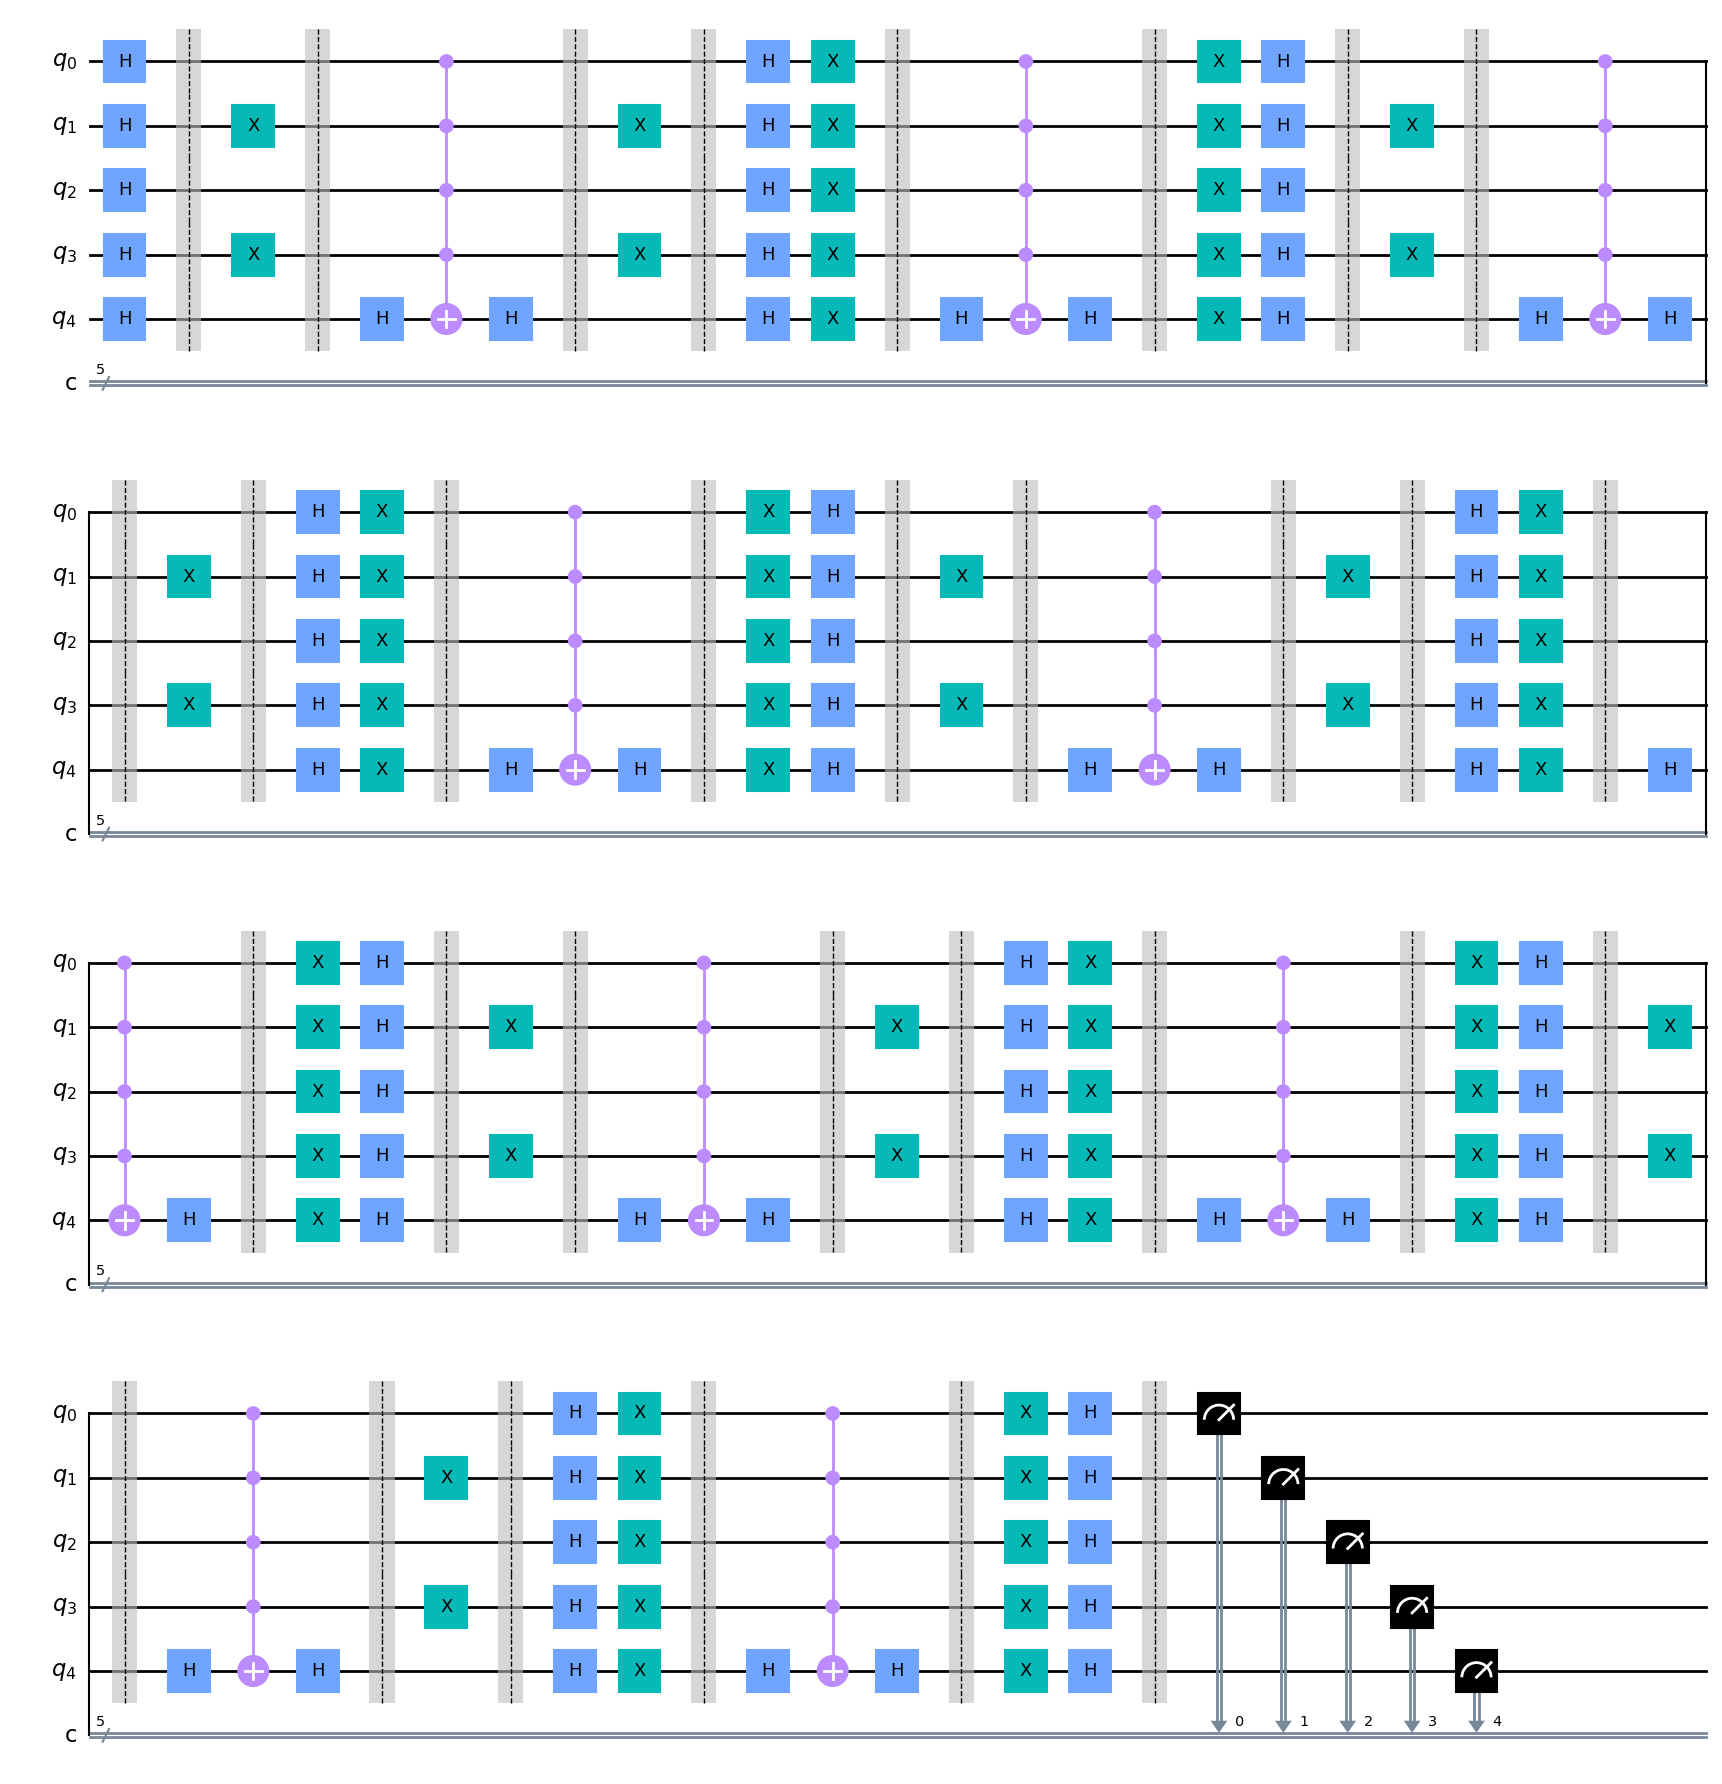

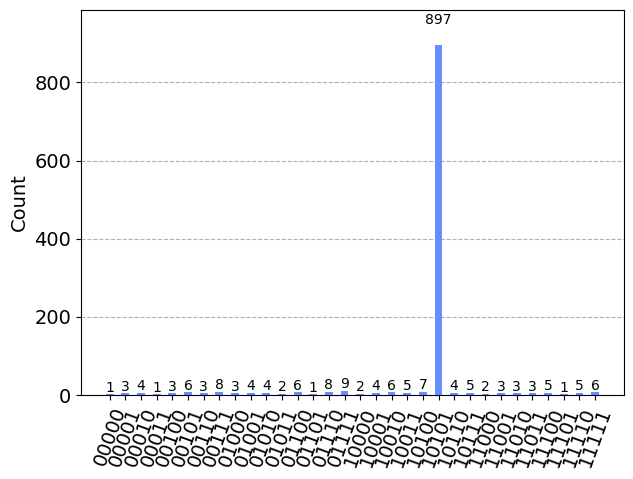

In [29]:
qc , counts = create_grover_circ('10101')
display(qc.draw('mpl'))
display(plot_histogram(counts))

#### 4. On ne répéte que deux fois l'opérateur de Grover

Pour rechercher $\ket{10101} $:

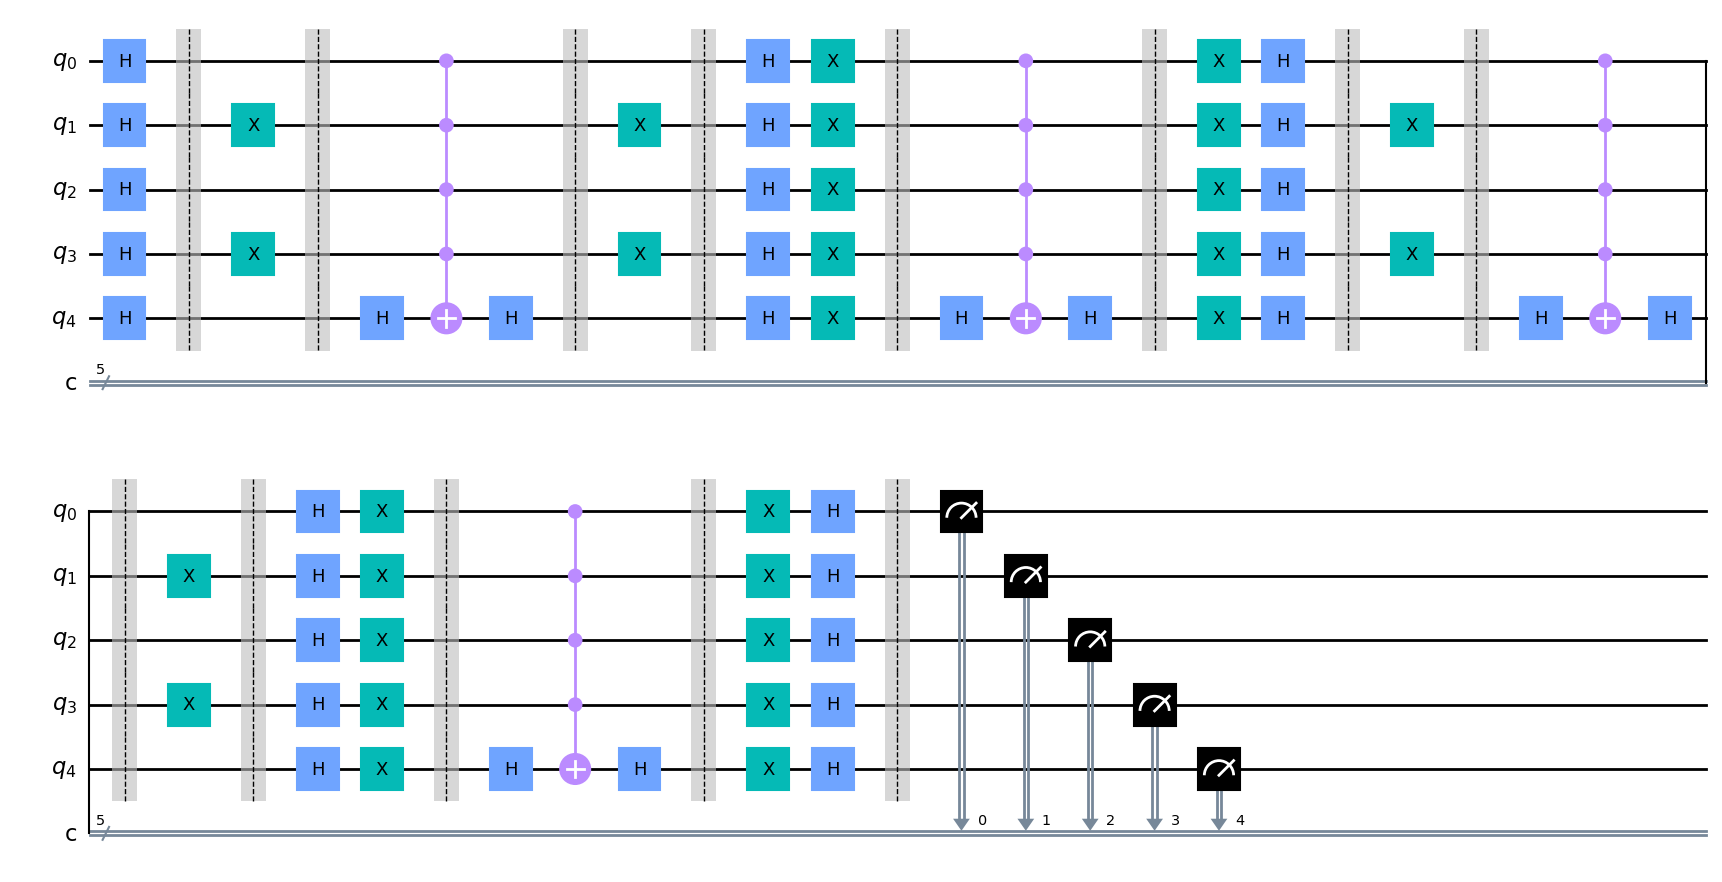

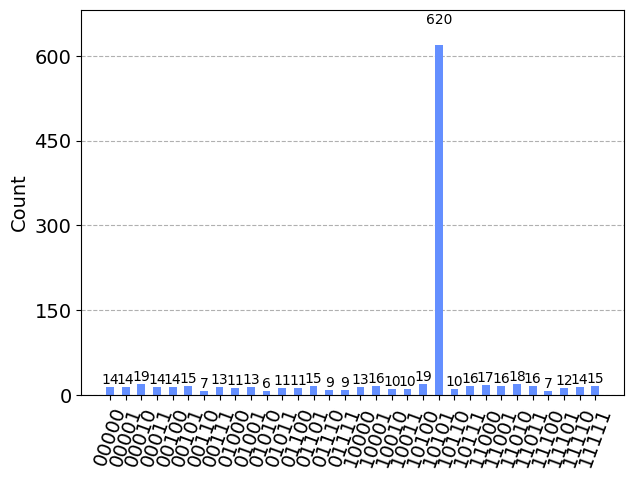

In [30]:
qc, counts = create_grover_circ('10101', num_grover_iteration=2)
display(qc.draw('mpl'))
display(plot_histogram(counts))

On voit que le résultat obtenu est certes plutôt préçis mais quand même moins que lorsque que l'on fait 5 itérations. Si on l'execute encore une autre fois on s'attend à avoir un résultat plus préçis.

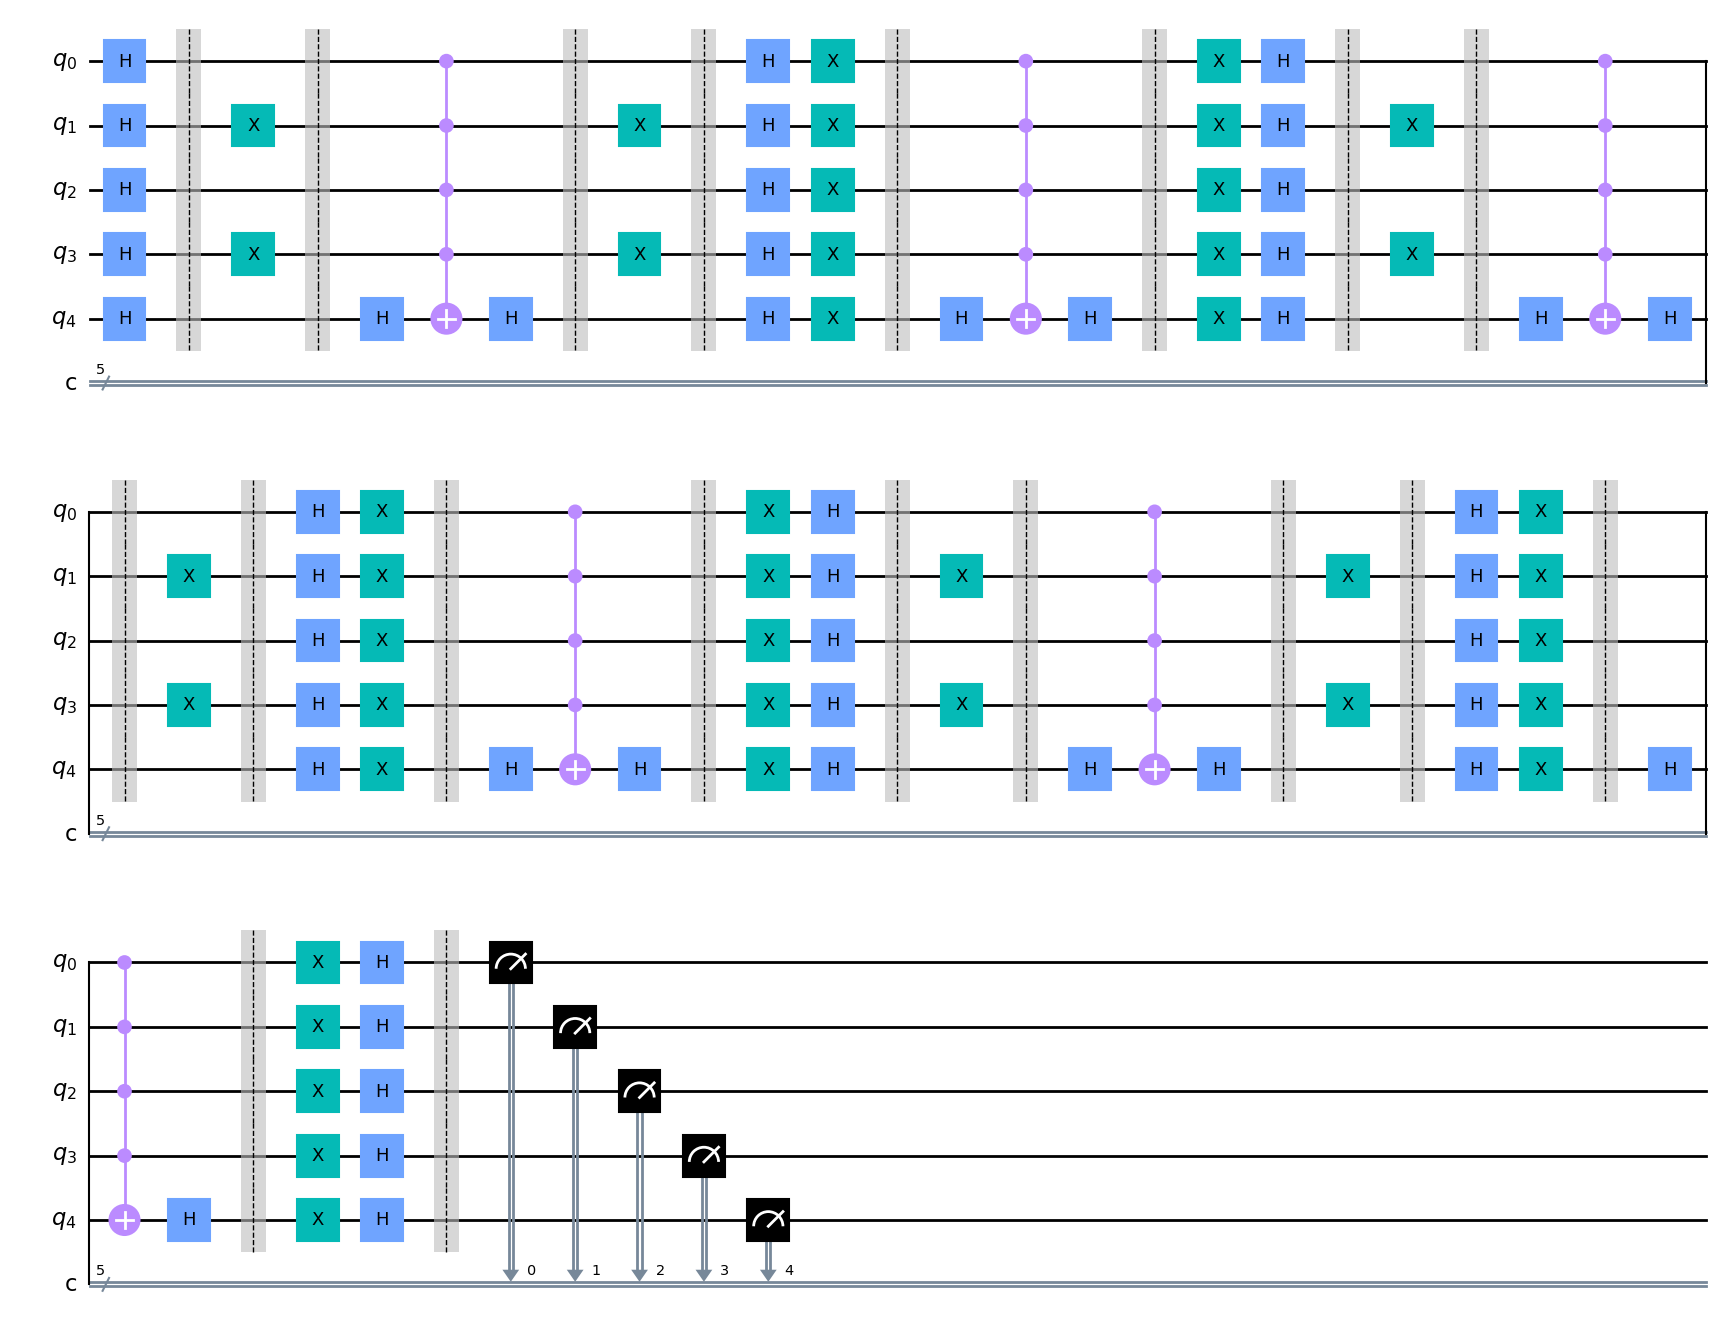

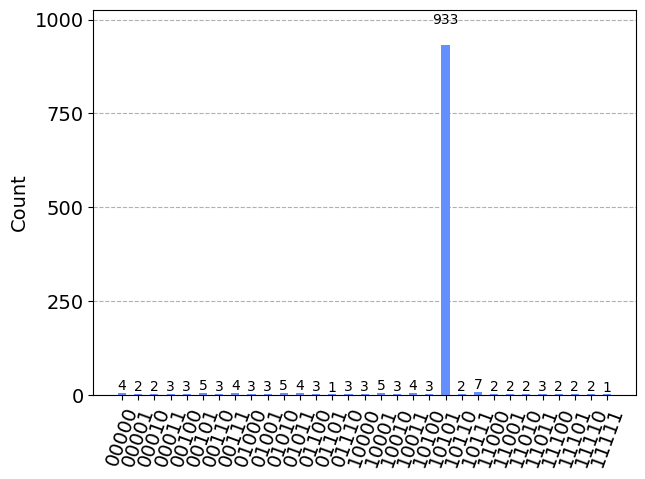

In [32]:
qc, counts = create_grover_circ('10101', num_grover_iteration=3)
display(qc.draw('mpl'))
display(plot_histogram(counts))